# Ensemble - Gradient Boosting

## References

https://www.kaggle.com/datasets/yasserh/bmidataset

## Import Python Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [61]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [62]:

# Source: https://www.kaggle.com/datasets/yasserh/bmidataset

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X1: Gender : Male / Female
# X2: Height : Number (cm)
# X3: Weight : Number (Kg)
#  y: Index : 
  # ----------
  # 0 - Extremely Weak
  # 1 - Weak
  # 2 - Normal
  # 3 - Overweight
  # 4 - Obesity
  # 5 - Extreme Obesity

In [63]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/bmi.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [64]:
# identify X_cols and y_col
all_cols = df0.columns.values
y_col = 'Index'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [65]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X1,X2,X3,y
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [66]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X1      500 non-null    object
 1   X2      500 non-null    int64 
 2   X3      500 non-null    int64 
 3   y       500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [67]:
# describe data
df1.describe()

,X2,X3,y
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


In [68]:
# check missing values
df1.isna().sum()

X1    0
X2    0
X3    0
y     0
dtype: int64

## Data Cleaning and Transformation

In [69]:
df1.head()

,X1,X2,X3,y
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [70]:
# response column
y_col = new_y_col
y_col

'y'

In [71]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X1', 'X2', 'X3'], dtype='object')

In [72]:
# get unique y_labels
y_labels = ['Extremely Weak', 'Weak', 'Normal', 'Overweight', 'Obesity', 'Extreme Obesity']
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'Extremely Weak': 0,
 'Weak': 1,
 'Normal': 2,
 'Overweight': 3,
 'Obesity': 4,
 'Extreme Obesity': 5}

In [73]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X1,X2,X3,y
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [74]:
# remove rows with missing valus
for X in df1.columns.values:
  cond1 = ~((df1[X].isna()))
  df1 = df1.loc[cond1,:]
  
df1.isna().sum()

X1    0
X2    0
X3    0
y     0
dtype: int64

In [75]:
# check label distribution
temp_labels = list(y_labels.values())
cond_list = []
count_list = []
for i in np.arange(len(temp_labels)):
  # condition for rows matching response label
  # print(i)
  x = temp_labels[i]
  temp_cond = list(df1[y_col] == x)
  cond_list.append(temp_cond)
  # print(cond_list)
  # get total label count
  temp_n = np.sum(cond_list[i])
  # print(temp_n)
  count_list.append(temp_n)
  
# max label count
n_max = np.max(count_list)
# index where max value occurs
i_max = np.where(count_list == n_max)[0][0]
# index where max value does not occurs
i_notmax = np.where(count_list != n_max)[0]

print(temp_labels)
print(count_list)
print(n_max)
print(i_max)
print(i_notmax)

[0, 1, 2, 3, 4, 5]
[13, 22, 69, 68, 130, 198]
198
5
[0 1 2 3 4]


In [76]:
# upsample minority labels
df_upsample_list = []
for i in i_notmax:
  # print(i)
  # get dataframe rows where label exsists
  cond = cond_list[i]
  # print(cond)
  df_temp = df1.iloc[cond,:]
  # print(df_temp.info())
  
  # determine amount to upsample 
  n_diff = n_max - count_list[i]
  # print(n_diff)
  
  # generate upsample dataframe 
  df_upsample_temp = resample(
    df_temp,
    replace = True,
    n_samples = n_diff,
    random_state = random_state
  )
  df_upsample_list.append(df_upsample_temp)

# put all dataframes in df_upsample_list into one
df_upsample_list = pd.concat(df_upsample_list, ignore_index = True)

# update df1 with upsampled dataframe
df1 = pd.concat([df1, df_upsample_list], ignore_index = True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X1      1188 non-null   object
 1   X2      1188 non-null   int64 
 2   X3      1188 non-null   int64 
 3   y       1188 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 37.3+ KB


In [77]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X1,X2,X3,y
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


In [78]:
# update df1
X = df1[X_cols]
y = df1[y_col]
df1 = pd.concat([X, y], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      1188 non-null   int32
 1   X2      1188 non-null   int64
 2   X3      1188 non-null   int64
 3   y       1188 non-null   int64
dtypes: int32(1), int64(3)
memory usage: 32.6 KB


In [79]:
# normalize all X_cols
df2 = df1.copy()
# norm = StandardScaler()
# norm = MinMaxScaler()
norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X1,X2,X3,y
0,1.0,-0.250000,0.428571,4
1,1.0,0.375000,0.244898,2
2,0.0,0.208333,0.714286,4
3,0.0,0.625000,0.591837,3
4,1.0,-1.291667,-0.285714,3


## Visualize Dataset

In [80]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 5)

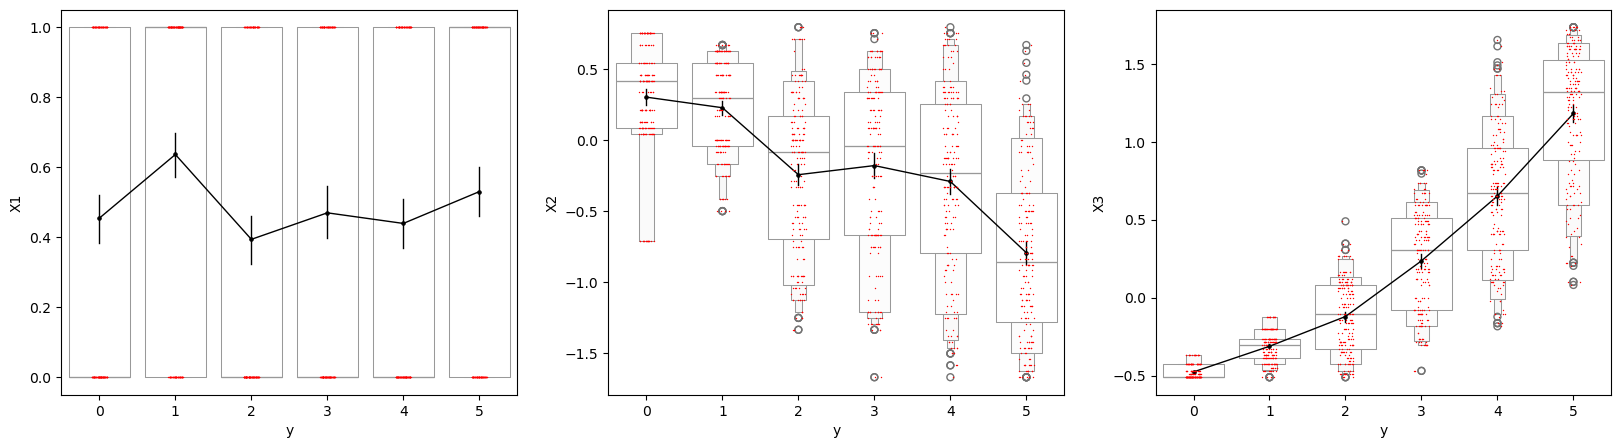

In [81]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [82]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [83]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [84]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(1188, 3)

In [85]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X1', 'X2', 'X3'], dtype=object)

In [86]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X1', 'X2', 'X3'], dtype=object)

### Select Features Using Model Selection Methods

In [87]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [88]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 20,
  # max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [89]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [90]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.01058592, 0.35106456, 0.63834952])

In [91]:
# threshold feature importance
# feature_importance_threshold = np.mean(feature_importance)
feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.75)
feature_importance_threshold

0.3510645620654857

In [92]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [93]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [94]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X2', 'X3'], dtype=object)

## Train and Test ML Model

In [95]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

2
['X2' 'X3']


In [96]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  stratify = y, shuffle = True, 
  train_size = 0.8, random_state = random_state
)

In [97]:
# initialize Gradient Boosting
myfit = GradientBoostingClassifier(
  n_estimators = 1000,
  random_state = random_state
)

In [98]:
# fit model
temp = myfit.fit(X_train, y_train)

In [99]:
# get predictions on test data
y_hat = myfit.predict(X_test)

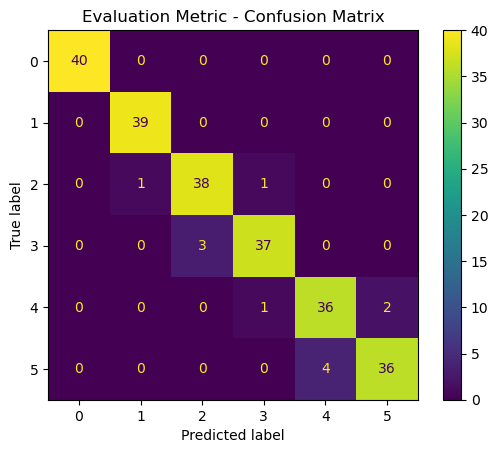

In [100]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [101]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      1.00      0.99        39
           2       0.93      0.95      0.94        40
           3       0.95      0.93      0.94        40
           4       0.90      0.92      0.91        39
           5       0.95      0.90      0.92        40

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238

